# Introduction

##### Problem Background


When multiple drugs are used in treatment of a patient, there is a possibility drugs interact, potentially causing harmful effects.
To reduce drug development time and uncover negative interactions before human trials, clinicians need a way to predict these drug interactions. This problem is combinatorially difficult due to the massive number of drugs, variations in drug features such as molecular structure, and the range of potential interactions. By using neural networks, clinicians could uncover patterns in drug interaction, enabling better understanding of drug functionality on the body. This understanding could not only discover negative drug interactions, but also secondary use-cases of drugs for treatment.


Traditional model architectures, such as proposed by $Rohani^{1}$ utilize drug-similarity matrices of features such as molecular substructure to predict interactions. These matrices are sub-selected for the most informative and fused into a singular matrix as input for a neural network. These approaches omit critical information about the kind of interactions between drugs, and simply discover any interaction. For clinicians to properly understand drug functionality and safety of use, they must be able to predict the severity and type of drug interactions.


Graph Neural Networks have recently been employed to encode and explore various drug interaction types. By encoding drugs as nodes, and interaction types as edges, models can better understand how drugs interact with one another. However, generating graph representations of drug interactions is challenging, particularly in how to combine various features from various sources and how to generate embeddings. $Lin et al^{2}$, generates a graph structure from various features, but only predicts the presence of an interaction from node locality - ignoring the semantic representation of features.


##### Paper Explanation

$Al-Rabeah^{3}$ improves upon both the traditional and GNN approaches by utilizing graph networks of various features to generate embeddings for feeding into a neural network for classification. The aim is to integrate both the similarity matrices of previous approaches with GNN embeddings of multiple featuresets, in order to represent a heterogeneous network for predicting the types of drug-drug interactions.


The work utilizes four feature matrices (Chemical structure, Target, Enzyme, and Pathway) as attributes for nodes representing drugs via similarity matrices, with edges being the drug-drug interaction. Each graph is then used to generate an embedding matrix with a vector for each drug and interaction type. This is done via a random walk from the drug node utilizing edges of the given interaction type to form a node sequence, which is then used to learn embeddings. These four embedding matrices are sliced and cross-multiplied within each other to represent drug-drug interactions. These vectors are then fed into neural networks for each matrix, using a softmax to generate probability vectors for all event types. These vectors are fed through ReLU activation to produce a final prediction vector.


The work tested using all subset of the feature matrices, with the best performance from usage all four matrices gathered. The results, achieving 0.9206, 0.9992, 0.9717, 0.8579, and 0.8259 Accuracy, AUC, AUPR, F1, and recall scores respectively, outperformed many recent DDI works. This showed significant improvement over traditional Neural Network approaches, such as CNN-DDI by $Zhang^{4}$. While other GNN approaches, such as the novel KGNN, achieved better performance in some metrics such as F1 score - their analysis was over individual datasets and neglected several features. From this, the GNN-DDI architecture showed exceptional performance as it was faced with multiple-datasets, indicating strong usage across various features.


The work of $Al-Rabeah^{3}$ showed the strength of combining various feature sets for generating neural network inputs. Likewise, the paper exemplified the utility in combining multiple components of past approaches (GNN and fusion of multiple similarity matrix results) to produce a robust architecture performant over  features from multiple datasets.



# Scope of Reproducibility

All of our efforts, including this notebook, pre-computed models, processed data, etc. are located within [our teams Github repository](https://github.com/NealRyan/Drug-drug-interaction-modeling/blob/main). For our project, we utilized the [papers authors code repository](https://github.com/Mohammad-Hussain95/GNN_DDI/tree/main/).

The original code was written in Tensorflow and was extremely hard to understand and modify, using obscure, lengthy matrix transformations to perform general operations. We first re-implemented the entire code repository of the paper using PyTorch.  By re-writing in PyTorch, we found it easier to implement various modifications/ablations within the original codebase. This is the extent of our work for the initial draft.


With the Pytorch code, we plan to test the below hypotheses and ablations in our final report:


1. Hyperparameter Tuning.
   By varying the below hyperparameters, we attempt to achieve a higher performance from the model. The paper performs minimal hyperparameter tuning, so we anticipate minor tuning to significantly improve performance. In addition, the original paper uses the Adam optimizer which is relatively fast to converge on local minima. By optimizing parameters, we could achieve a better minimum for training our models.
   - Layer size
       - Varying the sizes of intermediary layers can constrain the model's performance to fit to training data. By reducing intermediary layer size, we can have a looser bias to the training set. This could be used to lower dropout rate, enabling faster training without sacrificing model generalization.
   - Number of dense layers
       - The dataset utilized by the paper is unbalanced leading to underfitting. We anticipate increasing the number of dense layers (2) within the neural networks will result in a more biased model - which could better fit the intricacies of less prevalent drug-drug interactions.
   - Dropout rate
       - The paper uses a dropout rate of 0.3 to inject random noise and reduce bias. By modifying dropout rate, alongside changes to layer size, we anticipate the same model generalization with improved fitting to training data.
2. Removing Dropout, and replacing with optimizer weight decay.
   Dropout introduces randomness into the network, while weight decay promotes a balanced model by regulating heavy weights. We anticipate weight decay to more effectively account for relations in similarity matrices, particularly for interactions less present in the training set, leading to a higher CV score.
3. Replacing the Adam optimizer with SGD.
   The paper did not tune the parameters of the Adam optimizer, which likely led to convergence on a suboptimal minima. SGD is less likely to converge on these minima, and should result in better generalizability than untuned Adam.
4. Removal of dropout layers.
   The proposed GNN relies on two hidden-layer 0.3 rate dropout layers to prevent overfitting. We will test the removal of each hidden layer, as well as both layers. By removing these layers, we can evaluate how tightly model overfits to the similarity matrices.
5. Removal of early stopping
   The code utilizes early stopping to prevent model overfitting if performance doesn’t improve in 10 epochs. We will remove this limitation, and attempt to overfit our network while retaining dropout. This will help evaluate how injected noise impacts performance.
6. Combining of 4 feedforward networks into 1
   The paper uses 4 feedforward networks to evaluate each property type independently and aggregates the results, however this does not capture any interactions between property types. We will test concatenating the feature vectors from each property type and using a single feedforward network with this feature vector.



# Methodology

Directly below we cover our data and how we processed it. Further in the notebook (near the relevant code cells) we explain our models, model training, and evaluation.

### Data


The paper utilizes four 2-D feature matrices of 572 drugs, derived from different databases:
* Chemical Structure
   - SMILE strings, ASCII representations, of drug molecule structures. Commonly used to encode molecular structure.
* Target
   - The molecule in the body which drug is intended to impact.
* Enzyme
   - The enzyme responsible for processing a drug within the body. Enzymes can degrade molecules into derivatives.
* Pathway
   - The specific pathway through which drugs are absorbed, distributed, metabolized, and excreted from the body.

All feature matrices were derived from the DrugBank database, and sourced from $Deng et al^{5}$ as an _eventdb_. The Pathway feature matrix also includes data from the KEGG database. Each column in the matrices represents an individual drug, while the rows are 1-hot encodings of the presence of drug properties. As a result, each matrix varies in the length of the second axis.


To achieve a representation of drug interactions, each of these feature matrices are transformed into similarity matrices via Jacquard similarity function. This results in uniform 572x572 similarity feature matrices. These similarity matrices were provided, however we also utilized our own code to derive these matrices. The similarity matrices become the node attributes for our various graphs.


In addition, the paper utilizes an interaction matrix, describing 65 types of interactions between the 572 drugs (as well as no interaction). These 65 (66) types are the types of DDI events extracted by $Deng et al^{5}$. This matrix is used as the nodes and edges of our drug graphs.
The matrix has 4 dimensions:
- Drug 1
- Drug 2
   * Note, since there is no causal relationship between the drugs, Drug 1 and Drug 2 for a given row can be swapped.
- Mechanism of drug interaction
- If interaction is increased or decreased 

From this, the paper can derive two submatrices: the presence of drug interactions and interaction types. The distribution of the data is extremely uneven across event types, resulting in underfitting to the less represented event. This fact informed the basis of many of our experiments - as we try to appropriately fit the model for these events.

We perform analysis over these different matrices in the below sections.


# Notebook Setup

* For running this notebook, we recommend using Python (3.9.6).
* Our requirements are listed in `requirements.in` and pip-compiled to explicit versions in `requirements.txt`.
* To install the requirements defined in `requirements.txt`:
    * Run the below cell.
* To update requirements:
    * Update `requirements.in` for desired requirements.
    * Run the below command to compile to `requirements.txt`:
        * `python -m piptools compile requirements.in`

In [1]:
import logging
from pathlib import Path
from PIL import Image
logging.basicConfig(level=logging.INFO)

import requests
def download_file(url: str, file_path: Path, is_picture=False) -> None:
    with file_path.open('wb') as file:
        if is_picture:
            img = Image.open(requests.get(url, stream = True).raw)
            img.save(file_path)
        else:
            response = requests.get(url)
            file.write(response.content)
    logging.info(f'Downloaded file to {file_path}')

Path("./pictures").mkdir(exist_ok=True)
download_file("https://raw.githubusercontent.com/NealRyan/Drug-drug-interaction-modeling/main/requirements.in", Path("./requirements.in"))
download_file("https://raw.githubusercontent.com/NealRyan/Drug-drug-interaction-modeling/main/requirements.txt", Path("./requirements.txt"))
download_file("https://github.com/NealRyan/Drug-drug-interaction-modeling/blob/95ae5ea7687deef981ceb50d6afc2cfaf15c815e/pictures/feature_embedding.png?raw=true", Path("./pictures/feature_embedding.png"), is_picture=True)
download_file("https://github.com/NealRyan/Drug-drug-interaction-modeling/blob/95ae5ea7687deef981ceb50d6afc2cfaf15c815e/pictures/neural_network.png?raw=true", Path("./pictures/neural_network.png"), is_picture=True)


INFO:root:Downloaded file to requirements.in
INFO:root:Downloaded file to requirements.txt
INFO:root:Downloaded file to pictures/feature_embedding.png
INFO:root:Downloaded file to pictures/neural_network.png


In [2]:
!pip install -r requirements.txt

### Notebook Configuration

This paper has several steps:
* Download event_db and extract raw drug attributes and interaction data.
* Train GNN models and generate graph embeddings
* Train NN

For ease of running, we will enable feature_flags, selecting to either fully run each step OR download from precomputed sources. Any step can be toggled on/off in the below cell. The precomputed resources are stored in [our teams github repository](https://github.com/NealRyan/Drug-drug-interaction-modeling/tree/main).

For the best performance, use precomputed data by setting:
```_ALWAYS_GENERATE_DATA = False```. This will be the default setting to remain within time limits of the project.

In [3]:
# Notebook feature flags.

# == Global Flags ==

# Set the below flag to ALWAYS generate data.
# This option is extremely slow, as we perform all operations manually,
# rather than useprecomputed data/models.
_ALWAYS_GENERATE_DATA = False

# Set the below flag to save data locally ("checkpoint").
# This flag only takes affect for steps generating data.
_ALWAYS_SAVE_DATA = True


# Default Feature Flags

# == Data Flags == 

# Download event db and manually construct jaccard similarity matrices
_CONSTRUCT_JACCARD_MATRICES = False

# Download event db and manually construct drug interaction matrices
_CONSTRUCT_INTERACTION_MATRICES = False

# == Training Flags == 

# Train GNNs and generate embeddings
_TRAIN_GNN_MODELS_AND_GENERATE_EMBEDDINGS = False

# Train final dense NNs
_TRAIN_NN = False

if _ALWAYS_GENERATE_DATA:
    _CONSTRUCT_JACCARD_MATRICES = True
    _CONSTRUCT_INTERACTION_MATRICES = True
    _TRAIN_GNN_MODELS_AND_GENERATE_EMBEDDINGS = True
    _TRAIN_NN = True

In [4]:
import pandas as pd
from dataclasses import dataclass
from pathlib import Path
from tempfile import NamedTemporaryFile
import torch

@dataclass
class LocalRemotePath:
    """Dataclass for maintaining a local and remove version of checkpointed data."""

    local: Path
    remote: str

    def __init__(self, file_name, remote_url):
        self.local = _CHECKMARKS_FOLDER / f"{file_name}.parquet"
        self.remote = remote_url

    def download_as_df(self) -> pd.DataFrame:
        if self.local.exists():
            logging.debug(f"using local dataframe {self.local}")
            return pd.read_parquet(self.local)
        logging.debug(f"Downloading from {self.remote}")
        if self.remote.endswith("parquet"):
            return pd.read_parquet(self.remote)
        return pd.read_csv(self.remote, header=None)

    def to_parquet(self, dataframe) -> None:
        dataframe.to_parquet(self.local)
        logging.info(f"Saved dataframe to {self.local}")

    def save_model(self, state_dict) -> None:
        torch.save(state_dict, self.local)
        logging.info(f"Saved dataframe to {self.local}")

    def load_model_state_dict(self):
        if self.local.exists():
            return torch.load(self.local, map_location=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu'))
        else:
            with NamedTemporaryFile() as f:
                download_file(self.remote, Path(f.name))
                return torch.load(f.name, map_location=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu'))


_CHECKMARKS_FOLDER = Path.cwd() / "checkmarks"
_CHECKMARKS_FOLDER.mkdir(exist_ok=True)

_REPO_BASE = "https://raw.githubusercontent.com/NealRyan/Drug-drug-interaction-modeling/main"
_CHECKMARKS_BASE = "https://github.com/NealRyan/Drug-drug-interaction-modeling/raw/main/checkmarks"
PATH_MAPPING = {
    "raw_target": LocalRemotePath("raw_target", f"{_CHECKMARKS_BASE}/raw_target.parquet"),
    "raw_enzyme": LocalRemotePath("raw_enzyme", f"{_CHECKMARKS_BASE}/raw_enzyme.parquet"),
    "raw_pathway": LocalRemotePath("raw_pathway", f"{_CHECKMARKS_BASE}/raw_pathway.parquet"),
    "raw_smile": LocalRemotePath("raw_smile", f"{_CHECKMARKS_BASE}/raw_smile.parquet"),
    "jaccard_target": LocalRemotePath("jaccard_target", f"{_CHECKMARKS_BASE}/jaccard_target.parquet"),
    "jaccard_enzyme": LocalRemotePath("jaccard_enzyme", f"{_CHECKMARKS_BASE}/jaccard_enzyme.parquet"),
    "jaccard_pathway": LocalRemotePath("jaccard_pathway", f"{_CHECKMARKS_BASE}/jaccard_pathway.parquet"),
    "jaccard_smile": LocalRemotePath("jaccard_smile", f"{_CHECKMARKS_BASE}/jaccard_smile.parquet"),
    "pca_jaccard_target": LocalRemotePath("pca_jaccard_target", f"{_CHECKMARKS_BASE}/pca_jaccard_target.parquet"),
    "pca_jaccard_enzyme": LocalRemotePath("pca_jaccard_enzyme", f"{_CHECKMARKS_BASE}/pca_jaccard_enzyme.parquet"),
    "pca_jaccard_pathway": LocalRemotePath("pca_jaccard_pathway", f"{_CHECKMARKS_BASE}/pca_jaccard_pathway.parquet"),
    "pca_jaccard_smile": LocalRemotePath("pca_jaccard_smile", f"{_CHECKMARKS_BASE}/pca_jaccard_smile.parquet"),
    "pos": LocalRemotePath("pos", f"{_CHECKMARKS_BASE}/pos.parquet"),
    "neg": LocalRemotePath("neg", f"{_CHECKMARKS_BASE}/neg.parquet"),
    "raw": LocalRemotePath("raw", f"{_CHECKMARKS_BASE}/raw.parquet"),
    "embeddings_enzyme": LocalRemotePath("embeddings_enzyme", f"{_REPO_BASE}/Data/Embedding%20Matrices/enzyme_drug_embedding_matrix.csv"),
    "embeddings_target": LocalRemotePath("embeddings_target", f"{_REPO_BASE}/Data/Embedding%20Matrices/target_drug_embedding_matrix.csv"),
    "embeddings_smile": LocalRemotePath("embeddings_substructure", f"{_REPO_BASE}/Data/Embedding%20Matrices/substructure_drug_embedding_matrix.csv"),
    "embeddings_pathway": LocalRemotePath("embeddings_pathway", f"{_REPO_BASE}/Data/Embedding%20Matrices/pathway_drug_embedding_matrix.csv"),
    "graph_scores_enzyme": LocalRemotePath("graph_scores_enzyme", f"{_REPO_BASE}"),
    "graph_scores_target": LocalRemotePath("graph_scores_target", f"{_REPO_BASE}"),
    "graph_scores_smile": LocalRemotePath("graph_scores_substructure", f"{_REPO_BASE}"),
    "graph_scores_pathway": LocalRemotePath("graph_scores_pathway", f"{_REPO_BASE}"),
    "model_enzyme": LocalRemotePath("model_enzyme", f"https://github.com/NealRyan/Drug-drug-interaction-modeling/raw/main/Model%20Files/enzyme_model_best_model.pth"),
    "model_target": LocalRemotePath("model_target", f"https://github.com/NealRyan/Drug-drug-interaction-modeling/raw/main/Model%20Files/target_model_best_model.pth"),
    "model_smile": LocalRemotePath("model_substructure", f"https://github.com/NealRyan/Drug-drug-interaction-modeling/raw/main/Model%20Files/substructure_model_best_model.pth"),
    "model_pathway": LocalRemotePath("model_pathway", f"https://github.com/NealRyan/Drug-drug-interaction-modeling/raw/main/Model%20Files/pathway_model_best_model.pth"),
}

### Extract Raw Feature Data

Download and extract raw feature data from event_db (from Deng et al) and convert into the required Jacard similarity matrices.

In [5]:
import requests
import sqlite3

import numpy as np
import logging

from typing import List, Mapping
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.decomposition import PCA
from collections import OrderedDict, Counter

# Constants

_EVENT_DB_URL: str = 'https://raw.githubusercontent.com/NealRyan/Drug-drug-interaction-modeling/main/Data/Raw%20Event%20DB/event.db'
_EVENT_DB_FILE_PATH: Path = _CHECKMARKS_FOLDER / "event_db.txt"

_FEATURE_TYPES = {"target", "enzyme", "pathway", "smile"}
_RAW_FEATURE_SERIES = {}
_FEATURE_JAC_MATRICES = {}
_FEATURE_PCA_MATRICES = {}

class IncreasingOrderedDict(OrderedDict):
    """Ordered Dict with values being the insertion order"""

    _cur_val: int = 0

    def add_item(self, key) -> int:
        if key in self.keys():
            return self[key]
        self[key] = self._cur_val
        self._cur_val += 1
        return self[key]

    def add_items(self, keys) -> list[int]:
        return [self.add_item(key) for key in keys]

def download_and_generate_matrices():
    """Manually download and generate Jaccard similarity matrices."""

    # Download event and extract raw features
    download_file(_EVENT_DB_URL, _EVENT_DB_FILE_PATH)

    conn = sqlite3.connect(_EVENT_DB_FILE_PATH)

    df_raw_drug = pd.read_sql('select * from drug;', conn)

    # close the DB connection
    conn.close()

    # Transform downloaded raw features into jaccard similarity matrices.
    num_drugs = len(df_raw_drug.index)
    for feature in _FEATURE_TYPES:
        raw_feature_series = df_raw_drug[feature]

        # Generate a global list of all elements
        # and a mapping of drug idx to its relevant elements
        element_dict = IncreasingOrderedDict()
        element_dict_counter = Counter()
        drug_element_mapping = {}
        for drug_idx, cell in enumerate(raw_feature_series):
            split_element_list = cell.split('|')
            element_dict.add_items(split_element_list)
            element_dict_counter += Counter(split_element_list)
            drug_element_mapping[drug_idx] = element_dict.add_items(split_element_list)

        # For each drug, set its relevant elements values to False
        jaccard = np.full((num_drugs, len(element_dict.keys())), False)
        for drug_idx, element_idxs in drug_element_mapping.items():
            jaccard[drug_idx, element_idxs] = True

        jac_sim = 1 - pairwise_distances(jaccard, metric='jaccard')

        jac_sim_df = pd.DataFrame(jac_sim)
        
        # Perform PCA on jac_sim
        pca = PCA(n_components=len(jac_sim))
        pca.fit(jac_sim)
        jac_pca_df = pd.DataFrame(pca.transform(jac_sim))

        # Save dataclass for later use.
        _RAW_FEATURE_SERIES[feature] = pd.DataFrame.from_dict({"elements": element_dict_counter.keys(), "count": element_dict_counter.values()})
        _FEATURE_JAC_MATRICES[feature] = jac_sim_df
        _FEATURE_PCA_MATRICES[feature] = jac_pca_df

        if _ALWAYS_SAVE_DATA:
            PATH_MAPPING[f"raw_{feature}"].to_parquet(pd.DataFrame.from_dict({"elements": element_dict_counter.keys(), "count": element_dict_counter.values()}))
            PATH_MAPPING[f"jaccard_{feature}"].to_parquet(jac_sim_df)
            PATH_MAPPING[f"pca_jaccard_{feature}"].to_parquet(jac_pca_df)
            

def load_precomputed_similarity_matrices() -> None:
    """Load precomputed Jacard similarity matrices."""
    logging.info("Using precomputed similarity matrices.")
    for feature in _FEATURE_TYPES:
        _RAW_FEATURE_SERIES[feature] = PATH_MAPPING[f"raw_{feature}"].download_as_df()
        _FEATURE_JAC_MATRICES[feature] = PATH_MAPPING[f"jaccard_{feature}"].download_as_df()
        _FEATURE_PCA_MATRICES[feature] = PATH_MAPPING[f"pca_jaccard_{feature}"].download_as_df()

if _CONSTRUCT_JACCARD_MATRICES:
    download_and_generate_matrices()
else:
    load_precomputed_similarity_matrices()


INFO:root:Using precomputed similarity matrices.


### Extract drug event type interactions from event_db (from Deng et al)

These interactions will be used to form our positive examples, negative examples, and a complete list of drug-drug interactions for use in generating our graph embedding.

In [6]:
event_dfs = {
    'pos': None,
    'neg': None,
    'raw': None,
}

def generate_drug_interaction_matrices() -> None:
    conn = sqlite3.connect(_EVENT_DB_FILE_PATH)
    df_raw_extraction = pd.read_sql('select * from extraction;', conn)
    df_raw_drug = pd.read_sql('select * from drug;', conn)
    conn.close()

    df_raw_drug = df_raw_drug.set_index('name') 

    df_raw_extraction['event'] = df_raw_extraction['mechanism'] + ' ' + df_raw_extraction['action']

    df_raw_events = df_raw_extraction['event'].value_counts().to_frame()
    df_raw_events['event_index'] = np.arange(df_raw_events.shape[0])

    df_raw_full_pos = df_raw_extraction.join(df_raw_events, on='event')[['drugA', 'drugB', 'event_index']]
    df_raw_full_pos = df_raw_full_pos.join(df_raw_drug['index'], on='drugA')
    df_raw_full_pos = df_raw_full_pos.join(df_raw_drug['index'], on='drugB', rsuffix='_drugB')
    df_raw_full_pos = df_raw_full_pos[['event_index', 'index', 'index_drugB']]

    df_raw_events = df_raw_events.reset_index()[['event', 'count']]

    used_pairs = np.identity(len(df_raw_drug.index))
    # could also sort ints to ensure consistent ordering instead of making matrix symmetrical
    for _, row in df_raw_full_pos.iterrows():
        used_pairs[row['index'], row['index_drugB']] = 1
        used_pairs[row['index_drugB'], row['index']] = 1

    df_raw_all_neg = np.zeros((len(df_raw_full_pos.index), 2))

    count = 0
    while count < len(df_raw_all_neg):
        # could also sort ints to ensure consistent ordering instead of making matrix symmetrical
        rand_pair = np.random.randint(len(df_raw_drug.index), size=2)
        while used_pairs[rand_pair[0], rand_pair[1]] == 1 or used_pairs[rand_pair[1], rand_pair[0]] == 1:
            rand_pair = np.random.randint(len(df_raw_drug.index), size=2)

        used_pairs[rand_pair[0], rand_pair[1]] = 1
        used_pairs[rand_pair[1], rand_pair[0]] = 1
        df_raw_all_neg[count] = rand_pair
        count += 1

    df_raw_all_neg = pd.DataFrame(df_raw_all_neg, columns=['drug1', 'drug2'], dtype=np.int64)
    df_raw_full_pos = df_raw_full_pos.rename(columns={'event_index': 'event_num', 'index': 'drug1', 'index_drugB': 'drug2'})

    event_dfs['pos'] = df_raw_full_pos
    event_dfs['neg'] = df_raw_all_neg
    event_dfs['raw'] = df_raw_events

    if _ALWAYS_SAVE_DATA:
        for key, df in event_dfs.items():
            PATH_MAPPING[key].to_parquet(df)
        

def load_precomputed_interaction_matrices() -> None:
    for key in event_dfs.keys():
        event_dfs[key] = PATH_MAPPING[key].download_as_df()

if _CONSTRUCT_INTERACTION_MATRICES:
    generate_drug_interaction_matrices()
else:
    load_precomputed_interaction_matrices()


### Data Analysis

In the below cell, we analyze the raw data (all four feature matrices) as well as the drug-drug interactions.

#### Feature Analysis

From our four raw features, we jabve the below unique values:
* 202 unique enzymes
* 1162 unique drug targets
* 583 unique smile paths
* 957 unqiue pathways

The distribution of target, smile, and pathways encodings are largely even. The distribution for enzymnes are skewed towards the most commonly impacted enzymes.

Following processing, all similarity matrices have a shape of 572x572. This is a result of the jaccard similarity, which we use to represent relationships between drug features. These matrices will be the node attributes within our GNNs to generate embeddings for prediction by our final models.

#### Interaction Analyis

As shown below, we have an even distribution of "positive" (interaction) and "negative" (no-interaction) events for 37264 each, with a total for 65 unique interaction types. However, we have a massive skew in interaction type (shown by index and head) with 3 interaction types accounting for 66% of the interactions. This massive skew will make it difficult for the model to train to less prevalent interactions.


INFO:root:=== Feature Analysis ===
INFO:root:smile number of unique values: 583
INFO:root:enzyme number of unique values: 202
INFO:root:pathway number of unique values: 957
INFO:root:target number of unique values: 1162
INFO:root:smile similarity matrix shape: (572, 572)
INFO:root:enzyme similarity matrix shape: (572, 572)
INFO:root:pathway similarity matrix shape: (572, 572)
INFO:root:target similarity matrix shape: (572, 572)
INFO:root:=== Interaction Analysis ===
INFO:root:Number of positive samples: 37264
INFO:root:Number of negative samples: 37264
INFO:root:Number of total raw events: 37264
INFO:root:Number of unique event types: 65


,event,count
0,The metabolism decrease,9810
1,The risk or severity of adverse effects increase,9496
2,The serum concentration increase,5646
3,The serum concentration decrease,2386
4,The therapeutic efficacy decrease,1312


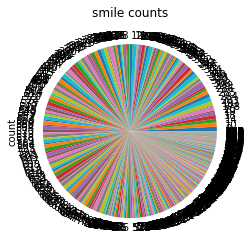

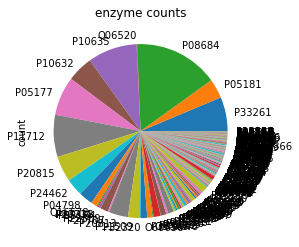

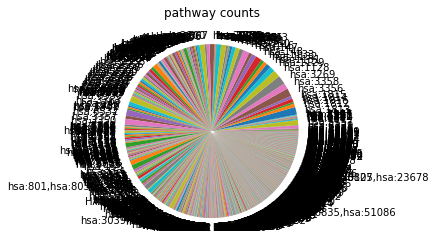

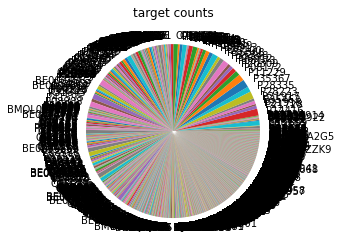

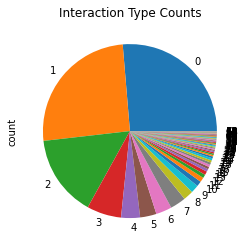

In [7]:
logging.info("=== Feature Analysis ===")

for feature_name, feature_df in _RAW_FEATURE_SERIES.items():
    logging.info(f"{feature_name} number of unique values: {len(feature_df)}")
    feature_df.set_index("elements").plot.pie(y="count", x='elements', title=f"{feature_name} counts", legend=False)

for feature_name, feature_df in _FEATURE_JAC_MATRICES.items():
    logging.info(f"{feature_name} similarity matrix shape: {feature_df.shape}")

logging.info("=== Interaction Analysis ===")

# Show basic descriptions of the interaction dataset.
logging.info(f"Number of positive samples: {len(PATH_MAPPING['pos'].download_as_df())}")
logging.info(f"Number of negative samples: {len(PATH_MAPPING['neg'].download_as_df())}")
logging.info(f"Number of total raw events: {PATH_MAPPING['raw'].download_as_df()['count'].sum()}")
logging.info(f"Number of unique event types: {PATH_MAPPING['raw'].download_as_df()['event'].nunique()}")

# Show plots and head of interactions.
PATH_MAPPING['raw'].download_as_df().plot.pie(y="count", title="Interaction Type Counts", legend=False)
PATH_MAPPING['raw'].download_as_df().head()



### GNN Training for Embedding Extraction

We will create graph embeddings. This will serve as the raw feature vector into our feed forward neural network.

To perform this, you will make a graph of nodes (drugs) and edges (events - event num). Four graphs in total are made (one for each of the properties we want to make embeddings for - enzyme, pathway, substructure, and target). The features of the nodes on the graph will be a column of the feature matrix, corresponding to it's similarity to each of the other drugs in the network on that property (enzyme for instance). A random walk of the graph with a context window is used to create the embeddings.

The output dimension of these graph embeddings is 572x32x66 which corresponds to the number of drugs x the embedding dimension x the number of events. The embedding dimension is a tuned hyperparameter from the original work, but can theoretically be changed. Finally, the last two dimensions of these matrices will be concatenated to form raw feature vectors for the nerual network (of dimension 572x2080 where 2080=32x65). "Raw" because we will still need to perform some further operations before they are ready to go. This process is represented pictorially below:

![image info](./pictures/feature_embedding.png)

##### GNN Model Configuration

In [8]:
# General training embeddings.

embedding_dim = 32  #Default 32
event_num = 65  #Default 65 DO NOT CHANGE
walk_length = 10 #Default 10
walks_per_node = 20 #Default 20
window_size = 5 #Default 5
negative_samples = 5 #Default 5
learning_rate = 0.01 #Default 0.01
global_epochs = 1 #Default 1
batch_size=64 #Default 64, lower this if RAM spikes are crashing Colab
num_workers=16 #Default 16
patience_num = 5 #no default (because we default to 1 epoch)
save_path = _CHECKMARKS_FOLDER
edge_dim = 10 #Degault 10
att_dim = 20 #Default 20
negative_samples = 5 #Default 5
neighbor_samples = 20 #Default 10
eval_type = 'all'

In [9]:
# Walk Helper Functions and Graph class definition.

import random
import multiprocess as mp

from tqdm import tqdm

def walk(args):
    walk_length, start, schema = args
    # Simulate a random walk starting from start node.
    rand = random.Random()

    if schema:
        schema_items = schema.split('-')
        assert schema_items[0] == schema_items[-1]

    walk = [start]
    while len(walk) < walk_length:
        cur = walk[-1]
        candidates = []
        for node in G[cur]:
            if schema == '' or node_type[node] == schema_items[len(walk) % (len(schema_items) - 1)]:
                candidates.append(node)
        if candidates:
            walk.append(rand.choice(candidates))
        else:
            break
    return [str(node) for node in walk]

def initializer(init_G, init_node_type):
    global G
    G = init_G
    global node_type
    node_type = init_node_type

class RWGraph():
    def __init__(self, nx_G, node_type_arr=None, num_workers=16):
        self.G = nx_G
        self.node_type = node_type_arr
        self.num_workers = num_workers

    def node_list(self, nodes, num_walks):
        for loop in range(num_walks):
            for node in nodes:
                yield node

    def simulate_walks(self, num_walks, walk_length, schema=None):
        all_walks = []
        nodes = list(self.G.keys())
        random.shuffle(nodes)

        if schema is None:
            with mp.Pool(self.num_workers, initializer=initializer, initargs=(self.G, self.node_type)) as pool:
                all_walks = list(pool.imap(walk, ((walk_length, node, '') for node in tqdm(self.node_list(nodes, num_walks))), chunksize=256))
        else:
            schema_list = schema.split(',')
            for schema_iter in schema_list:
                with mp.Pool(self.num_workers, initializer=initializer, initargs=(self.G, self.node_type)) as pool:
                    walks = list(pool.imap(walk, ((walk_length, node, schema_iter) for node in tqdm(self.node_list(nodes, num_walks)) if schema_iter.split('-')[0] == self.node_type[node]), chunksize=512))
                all_walks.extend(walks)

        return all_walks

##### Define graph edges
There are two choices for how to define the graph neural network:
* We can either include negative samples (drug-drug pairs that DO NOT interact with eachother)
* Omit negative examples.

We will emulate the original paper, which does *not* use negative examples. Thus we will only use the information from full_pos_df. If you change to another graph technique, it may be useful to use positive and negative examples.

In [10]:
# Helper functions for processing event data into graphs and generating graph walks.

import torch
from collections import defaultdict
from six import iteritems
from sklearn.metrics import (auc, f1_score, precision_recall_curve,
                             roc_auc_score)

@dataclass
class Vocab():
    count: int
    index: int

#Batches for training the GNN
def get_batches(pairs, neighbors, batch_size):
    n_batches = (len(pairs) + (batch_size - 1)) // batch_size

    for idx in range(n_batches):
        x, y, t, neigh = [], [], [], []
        for i in range(batch_size):
            index = idx * batch_size + i
            if index >= len(pairs):
                break
            x.append(pairs[index][0])
            y.append(pairs[index][1])
            t.append(pairs[index][2])
            neigh.append(neighbors[pairs[index][0]])
        yield torch.tensor(x), torch.tensor(y), torch.tensor(t), torch.tensor(neigh)

def get_G_from_edges(edges):
    edge_dict = defaultdict(set)
    for edge in edges:
        u, v = str(edge[0]), str(edge[1])
        edge_dict[u].add(v)
        edge_dict[v].add(u)
    return edge_dict

def load_training_data(dataframe):
    edge_data_by_type = defaultdict(list)
    all_nodes = list()
    for _, row in dataframe.iterrows():
        event_num, x, y = row["event_num"], row["drug1"], row["drug2"]
        edge_data_by_type[event_num].append((x,y))
        all_nodes.append(x)
        all_nodes.append(y)
    all_nodes = list(set(all_nodes))
    logging.info('Total training nodes: ' + str(len(all_nodes)))
    return edge_data_by_type


def load_testing_data(dataframe):
    true_edge_data_by_type = defaultdict(list)
    false_edge_data_by_type = defaultdict(list)
    all_nodes = list()
    for _, row in dataframe.iterrows():
        event_num, x, y, interaction = row["event_num"], row["drug1"], row["drug2"], row["interaction"]
        if int(interaction) == 1:
            true_edge_data_by_type[event_num].append((x, y))
        else:
            false_edge_data_by_type[event_num].append((x, y))
        all_nodes.append(x)
        all_nodes.append(y)
    all_nodes = list(set(all_nodes))
    return true_edge_data_by_type, false_edge_data_by_type

def generate_walks(network_data, num_walks, walk_length, schema, file_name, num_workers):
    if schema is not None:
        node_type = load_node_type(file_name + '/node_type.txt')
    else:
        node_type = None

    all_walks = []
    for layer_id, layer_name in enumerate(network_data):
        tmp_data = network_data[layer_name]
        # start to do the random walk on a layer

        layer_walker = RWGraph(get_G_from_edges(tmp_data), node_type, num_workers)
        logging.debug('Generating random walks for event_num', layer_id)
        layer_walks = layer_walker.simulate_walks(num_walks, walk_length, schema=schema)

        all_walks.append(layer_walks)

    logging.info('Finish generating the walks')

    return all_walks

def generate_pairs(all_walks, vocab, window_size, num_workers):
    pairs = []
    skip_window = window_size // 2
    for layer_id, walks in enumerate(all_walks):
        logging.debug('Generating training pairs for event_num', layer_id)
        for walk in tqdm(walks):
            for i in range(len(walk)):
                for j in range(1, skip_window + 1):
                    if i - j >= 0:
                        pairs.append((vocab[walk[i]].index, vocab[walk[i - j]].index, layer_id))
                    if i + j < len(walk):
                        pairs.append((vocab[walk[i]].index, vocab[walk[i + j]].index, layer_id))
    return pairs

def generate_vocab(all_walks):
    index2word = []
    raw_vocab = defaultdict(int)

    for layer_id, walks in enumerate(all_walks):
        logging.info('Counting vocab for event_num %s', layer_id)
        for walk in tqdm(walks):
            for word in walk:
                raw_vocab[word] += 1

    vocab = {}
    for word, v in iteritems(raw_vocab):
        vocab[word] = Vocab(count=v, index=len(index2word))
        index2word.append(word)

    index2word.sort(key=lambda word: vocab[word].count, reverse=True)
    for i, word in enumerate(index2word):
        vocab[word].index = i

    return vocab, index2word

def load_walks(walk_file):
    logging.info('Loading walks')
    all_walks = []
    with open(walk_file, 'r') as f:
        for line in f:
            content = line.strip().split()
            layer_id = int(content[0])
            if layer_id >= len(all_walks):
                all_walks.append([])
            all_walks[layer_id].append(content[1:])
    return all_walks

def save_walks(walk_file, all_walks):
    with open(walk_file, 'w') as f:
        for layer_id, walks in enumerate(all_walks):
            logging.debug('Saving walks for event_num', layer_id)
            for walk in tqdm(walks):
                f.write(' '.join([str(layer_id)] + [str(x) for x in walk]) + '\n')

def generate(network_data, num_walks, walk_length, schema, file_name, window_size, num_workers, walk_file):
    if walk_file is not None:
        all_walks = load_walks(walk_file)
    else:
        all_walks = generate_walks(network_data, num_walks, walk_length, schema, file_name, num_workers)
        save_walks(file_name / 'walks.txt', all_walks)
    vocab, index2word = generate_vocab(all_walks)
    train_pairs = generate_pairs(all_walks, vocab, window_size, num_workers)

    return vocab, index2word, train_pairs

def generate_neighbors(network_data, vocab, num_nodes, edge_types, neighbor_samples):
    edge_type_count = len(edge_types)
    neighbors = [[[] for __ in range(edge_type_count)] for _ in range(num_nodes)]
    for r in range(edge_type_count):
        logging.debug('Generating neighbors for event_num', r)
        g = network_data[edge_types[r]]
        for (x, y) in tqdm(g):
            ix = vocab[str(x)].index
            iy = vocab[str(y)].index
            neighbors[ix][r].append(iy)
            neighbors[iy][r].append(ix)
        for i in range(num_nodes):
            if len(neighbors[i][r]) == 0:
                neighbors[i][r] = [i] * neighbor_samples
            elif len(neighbors[i][r]) < neighbor_samples:
                neighbors[i][r].extend(list(np.random.choice(neighbors[i][r], size=neighbor_samples-len(neighbors[i][r]))))
            elif len(neighbors[i][r]) > neighbor_samples:
                neighbors[i][r] = list(np.random.choice(neighbors[i][r], size=neighbor_samples))
    return neighbors

def get_score(local_model, node1, node2):
    try:
        vector1 = local_model[node1]
        vector2 = local_model[node2]
        return np.dot(vector1, vector2) / (np.linalg.norm(vector1) * np.linalg.norm(vector2))
    except Exception as e:
        pass


def evaluate(model, true_edges, false_edges):
    true_list = list()
    prediction_list = list()
    true_num = 0
    for edge in true_edges:
        tmp_score = get_score(model, str(edge[0]), str(edge[1]))
        if tmp_score is not None:
            true_list.append(1)
            prediction_list.append(tmp_score)
            true_num += 1

    for edge in false_edges:
        tmp_score = get_score(model, str(edge[0]), str(edge[1]))
        if tmp_score is not None:
            true_list.append(0)
            prediction_list.append(tmp_score)

    sorted_pred = prediction_list[:]
    sorted_pred.sort()
    threshold = sorted_pred[-true_num]

    y_pred = np.zeros(len(prediction_list), dtype=np.int32)
    for i in range(len(prediction_list)):
        if prediction_list[i] >= threshold:
            y_pred[i] = 1

    y_true = np.array(true_list)
    y_scores = np.array(prediction_list)
    ps, rs, _ = precision_recall_curve(y_true, y_scores)
    return roc_auc_score(y_true, y_scores), f1_score(y_true, y_pred), auc(rs, ps)

In [11]:
# Define our model class.

import math
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter

class GATNEModel(nn.Module):
    def __init__(
        self, num_nodes, embedding_size, embedding_u_size, edge_type_count, dim_a, features
    ):
        super(GATNEModel, self).__init__()
        self.num_nodes = num_nodes
        self.embedding_size = embedding_size
        self.embedding_u_size = embedding_u_size
        self.edge_type_count = edge_type_count
        self.dim_a = dim_a

        self.features = None
        if features is not None:
            self.features = features
            feature_dim = self.features.shape[-1]
            self.embed_trans = Parameter(torch.FloatTensor(feature_dim, embedding_size))
            self.u_embed_trans = Parameter(torch.FloatTensor(edge_type_count, feature_dim, embedding_u_size))
        else:
            self.node_embeddings = Parameter(torch.FloatTensor(num_nodes, embedding_size))
            self.node_type_embeddings = Parameter(
                torch.FloatTensor(num_nodes, edge_type_count, embedding_u_size)
            )
        self.trans_weights = Parameter(
            torch.FloatTensor(edge_type_count, embedding_u_size, embedding_size)
        )
        self.trans_weights_s1 = Parameter(
            torch.FloatTensor(edge_type_count, embedding_u_size, dim_a)
        )
        self.trans_weights_s2 = Parameter(torch.FloatTensor(edge_type_count, dim_a, 1))

        self.reset_parameters()

    def reset_parameters(self):
        if self.features is not None:
            self.embed_trans.data.normal_(std=1.0 / math.sqrt(self.embedding_size))
            self.u_embed_trans.data.normal_(std=1.0 / math.sqrt(self.embedding_size))
        else:
            self.node_embeddings.data.uniform_(-1.0, 1.0)
            self.node_type_embeddings.data.uniform_(-1.0, 1.0)
        self.trans_weights.data.normal_(std=1.0 / math.sqrt(self.embedding_size))
        self.trans_weights_s1.data.normal_(std=1.0 / math.sqrt(self.embedding_size))
        self.trans_weights_s2.data.normal_(std=1.0 / math.sqrt(self.embedding_size))

    def forward(self, train_inputs, train_types, node_neigh):
        if self.features is None:
            node_embed = self.node_embeddings[train_inputs]
            node_embed_neighbors = self.node_type_embeddings[node_neigh]
        else:
            node_embed = torch.mm(self.features[train_inputs], self.embed_trans)
            node_embed_neighbors = torch.einsum('bijk,akm->bijam', self.features[node_neigh], self.u_embed_trans)
        node_embed_tmp = torch.diagonal(node_embed_neighbors, dim1=1, dim2=3).permute(0, 3, 1, 2)
        node_type_embed = torch.sum(node_embed_tmp, dim=2)

        trans_w = self.trans_weights[train_types]
        trans_w_s1 = self.trans_weights_s1[train_types]
        trans_w_s2 = self.trans_weights_s2[train_types]

        attention = F.softmax(
            torch.matmul(
                torch.tanh(torch.matmul(node_type_embed, trans_w_s1)), trans_w_s2
            ).squeeze(2),
            dim=1,
        ).unsqueeze(1)
        node_type_embed = torch.matmul(attention, node_type_embed)
        node_embed = node_embed + torch.matmul(node_type_embed, trans_w).squeeze(1)

        last_node_embed = F.normalize(node_embed, dim=1)

        return last_node_embed

In [12]:
# Define our custom loss function.

class NSLoss(nn.Module):
    def __init__(self, num_nodes, num_sampled, embedding_size):
        super(NSLoss, self).__init__()
        self.num_nodes = num_nodes
        self.num_sampled = num_sampled
        self.embedding_size = embedding_size
        self.weights = Parameter(torch.FloatTensor(num_nodes, embedding_size))
        self.sample_weights = F.normalize(
            torch.Tensor(
                [
                    (math.log(k + 2) - math.log(k + 1)) / math.log(num_nodes + 1)
                    for k in range(num_nodes)
                ]
            ),
            dim=0,
        )

        self.reset_parameters()

    def reset_parameters(self):
        self.weights.data.normal_(std=1.0 / math.sqrt(self.embedding_size))

    def forward(self, input, embs, label):
        n = input.shape[0]
        log_target = torch.log(
            torch.sigmoid(torch.sum(torch.mul(embs, self.weights[label]), 1))
        )
        negs = torch.multinomial(
            self.sample_weights, self.num_sampled * n, replacement=True
        ).view(n, self.num_sampled)
        noise = torch.neg(self.weights[negs])
        sum_log_sampled = torch.sum(
            torch.log(torch.sigmoid(torch.bmm(noise, embs.unsqueeze(2)))), 1
        ).squeeze()

        loss = log_target + sum_log_sampled
        return -loss.sum() / n

In [13]:
# Define our model training function.

def train_model(network_data, feature_dic, feature_name, valid_true_data_by_edge,
            valid_false_data_by_edge,
            testing_true_data_by_edge,
            testing_false_data_by_edge):
    vocab, index2word, train_pairs = generate(network_data, walks_per_node, walk_length, schema=None, file_name=save_path, window_size=window_size, num_workers=num_workers, walk_file=None)

    edge_types = list(network_data.keys())

    num_nodes = len(index2word)
    edge_type_count = len(edge_types)
    epochs = global_epochs
    #batch_size = args.batch_size
    embedding_size = embedding_dim
    embedding_u_size = edge_dim
    u_num = edge_type_count
    num_sampled = negative_samples
    dim_a = att_dim
    att_head = 1
    #neighbor_samples = neighbor_samples
    logging.debug(u_num)

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    neighbors = generate_neighbors(network_data, vocab, num_nodes, edge_types, neighbor_samples)

    features = None
    if feature_dic is not None:
        feature_dim = len(list(feature_dic.values())[0])
        logging.debug('feature dimension: ' + str(feature_dim))
        features = np.zeros((num_nodes, feature_dim), dtype=np.float32)
        for key, value in feature_dic.items():
            if key in vocab:
                features[vocab[key].index, :] = np.array(value)
        features = torch.FloatTensor(features).to(device)

    model = GATNEModel(
        num_nodes, embedding_size, embedding_u_size, edge_type_count, dim_a, features
    )
    nsloss = NSLoss(num_nodes, num_sampled, embedding_size)

    model = model.to(device)
    nsloss = nsloss.to(device)

    optimizer = torch.optim.Adam(
        [{"params": model.parameters()}, {"params": nsloss.parameters()}], lr=1e-4
    )

    logging.info(f'Beginning training for {feature_name} model')

    best_score = 0
    test_score = (0.0, 0.0, 0.0)
    patience = 0
    for epoch in range(epochs):
        random.shuffle(train_pairs)
        batches = get_batches(train_pairs, neighbors, batch_size)

        data_iter = tqdm(
            batches,
            desc="epoch %d" % (epoch),
            total=(len(train_pairs) + (batch_size - 1)) // batch_size,
            bar_format="{l_bar}{r_bar}",
        )
        avg_loss = 0.0

        for i, data in enumerate(data_iter):
            optimizer.zero_grad()
            embs = model(data[0].to(device), data[2].to(device), data[3].to(device),)
            loss = nsloss(data[0].to(device), embs, data[1].to(device))
            loss.backward()
            optimizer.step()

            avg_loss += loss.item()

            if i % 5000 == 0:
                post_fix = {
                    "epoch": epoch,
                    "iter": i,
                    "avg_loss": avg_loss / (i + 1),
                    "loss": loss.item(),
                }
                data_iter.write(str(post_fix))

        final_model = dict(zip(edge_types, [dict() for _ in range(edge_type_count)]))

        #initialize embeddings of all zeros
        final_embeddings = np.zeros((num_nodes, embedding_dim * u_num))

        for i in range(num_nodes):
            train_inputs = torch.tensor([i for _ in range(edge_type_count)]).to(device)
            train_types = torch.tensor(list(range(edge_type_count))).to(device)
            node_neigh = torch.tensor(
                [neighbors[i] for _ in range(edge_type_count)]
            ).to(device)
            node_emb = model(train_inputs, train_types, node_neigh)
            for j in range(edge_type_count):
                final_model[edge_types[j]][index2word[i]] = (
                    node_emb[j].cpu().detach().numpy()
                )

                #concatenate and save embeddings
                #where i loop is over the drugs (572)
                #and j loop is over the event_num (65)
                #concatenated_embeddings = torch.cat([node_emb[j].cpu().detach() for j in range(u_num)], dim=1)
                #final_embeddings[i, :] = concatenated_embeddings

        valid_aucs, valid_f1s, valid_prs = [], [], []
        test_aucs, test_f1s, test_prs = [], [], []
        for i in range(edge_type_count):
            if eval_type == "all":
                tmp_auc, tmp_f1, tmp_pr = evaluate(
                    final_model[edge_types[i]],
                    valid_true_data_by_edge[edge_types[i]],
                    valid_false_data_by_edge[edge_types[i]],
                )
                valid_aucs.append(tmp_auc)
                valid_f1s.append(tmp_f1)
                valid_prs.append(tmp_pr)

                tmp_auc, tmp_f1, tmp_pr = evaluate(
                    final_model[edge_types[i]],
                    testing_true_data_by_edge[edge_types[i]],
                    testing_false_data_by_edge[edge_types[i]],
                )
                test_aucs.append(tmp_auc)
                test_f1s.append(tmp_f1)
                test_prs.append(tmp_pr)
        logging.info("valid auc:", np.mean(valid_aucs))
        logging.info("valid pr:", np.mean(valid_prs))
        logging.info("valid f1:", np.mean(valid_f1s))

        average_auc = np.mean(test_aucs)
        average_f1 = np.mean(test_f1s)
        average_pr = np.mean(test_prs)

        cur_score = np.mean(valid_aucs)
        if cur_score > best_score:
            best_score = cur_score
            test_score = (average_auc, average_f1, average_pr)
            patience = 0
        else:
            patience += 1
            if patience > patience_num:
                logging.info("Early Stopping")
                break
    return test_score, final_model #final_embeddings

### Generate Train/Test/Validate Splits

We will now create our train, test, and validate splits from the drug-drug interaction dataframes we generated from the event_db.

We will use a standard (70-20-10, train, test, validation) split, giving us:
* 52169 training samples
* 14906 training samples
* 7453 validation samples

In [14]:
# Create test, train, and validation splits.

from sklearn.model_selection import train_test_split

#select equal number of negative examples from all_neg_df
num_negatives = len(event_dfs['pos'])
all_neg_sample = event_dfs['neg'].sample(n=num_negatives, random_state=42)

# Add an 'event_num' column with a placeholder value
all_neg_sample['event_num'] = -1

#Combine positive and negative examples for neural network training
nn_data = pd.concat([event_dfs['pos'], all_neg_sample]).reset_index(drop=True)

#split data into train, validation, and test sets (70-10-20 split)
train_df, test_df = train_test_split(nn_data, test_size=0.3, random_state=2)
valid_df, test_df = train_test_split(test_df, test_size=(2/3), random_state=2)  #split last 30% into 10% and 20% valid/test

# Define binary value based on presence of an interaction (event_num != -1)
test_df['interaction'] = test_df['event_num'].apply(lambda x: 1 if 0 <= x <= 64 else 0)
valid_df['interaction'] = valid_df['event_num'].apply(lambda x: 1 if 0 <= x <= 64 else 0)


In [15]:
# Train our GNNs and generate embeddings for all 4 feature matrices.

_FEATURE_EMBEDDINGS = {}
_GRAPH_TEST_SCORES = {}

def train_gnn_and_generate_embeddings() -> None:
    for name, feature_matrix in _FEATURE_PCA_MATRICES.items():
        #check if we've already processed this matrix (useful for colab limits)
        if name in _FEATURE_EMBEDDINGS:
            pass

        #load the train and test files using the helper functions
        training_data_by_type = load_training_data(train_df)
        valid_true_data_by_edge, valid_false_data_by_edge = load_testing_data(valid_df)
        testing_true_data_by_edge, testing_false_data_by_edge = load_testing_data(test_df)

        feature_dic = {idx: row.tolist() for idx, row in feature_matrix.iterrows()}

        #Obtain model outputs and print results
        _GRAPH_TEST_SCORES[name], _FEATURE_EMBEDDINGS[name] = train_model(
            training_data_by_type,
            feature_dic,
            name,
            valid_true_data_by_edge,
            valid_false_data_by_edge,
            testing_true_data_by_edge,
            testing_false_data_by_edge)
        average_auc, average_f1, average_pr = _GRAPH_TEST_SCORES[name]

        if _ALWAYS_SAVE_DATA:
            PATH_MAPPING[f"embeddings_{name}"].to_parquet(_FEATURE_EMBEDDINGS[name])
            PATH_MAPPING[f"graph_scores_{name}"].to_parquet(_GRAPH_TEST_SCORES[name])

        logging.info(f'Test Scores for {name} model:')
        logging.info(f'AUC: {average_auc}')
        logging.info(f'f1: {average_f1}')
        logging.info(f'pr: {average_pr}')

In [16]:
def load_precomputed_embeddings() -> None:
    for feature in _FEATURE_TYPES:
        _FEATURE_EMBEDDINGS[feature] = PATH_MAPPING[f"embeddings_{feature}"].download_as_df()
        #_GRAPH_TEST_SCORES[feature] = PATH_MAPPING[f"graph_scores_{feature}"].download_as_df()

In [17]:
if _TRAIN_GNN_MODELS_AND_GENERATE_EMBEDDINGS:
    train_gnn_and_generate_embeddings()
else:
    load_precomputed_embeddings()

## Model

#### Prepare for Neural Network

We currently have 572x2080 drug embedding matrices for each of the four properties we are using to help us predict if two drugs will interact (enzyme, pathway, substructure, and target). For each embedding matrix, we need to take a slice horizontally to represent the drug with all it's graph embedded event information (dimension 1x2080). This vector contains all the graph's embedded knowledge for ONE PARTICULAR drug. As this is a drug-drug interaction task, that won't quite be enough, so we now need to multiply it with each other drug to create the feature vectors for our neural network. We do this by elementwise multiplication of the vectors such that the end result will still be 1x2080.

#### Model Architecture

Replicating the paper, we will utilize a network with the architecture:

| Layer               | Input Dim | Output Dim | Activation Function | Dropout Rate |
| --------            | --------- | ---------- | ------------------- | ------------ |
| Linear              | 2080      | 512        | ReLU                |              |
| Batch Normalization | 512       |            |                     |              |
| Dropout             |           |            |                     | 0.3          |
| Linear              | 512       | 256        | ReLU                |              |
| Batch Normalization | 256       |            |                     |              |
| Dropout             |           |            |                     | 0.3          |
| Linear              | 256       | 65         |                     |              |


Separate networks will be instantiated for each of the four features. We then take the average of the four vectors to obtain the final output into a probability vector (with values from 0-1) of dimensions 1x66 (65+1, where the first index is for no interaction, and the other indices represent a reaction at that event_num+1).

#### Training Objectives

We will be using an Adam optimizer, due to it's robustness against untuned hyperparameters (as the paper doesn't tune parameters extensively). We will use a learning rate of *0.001*, optimizing CrossEntropyLoss as this is a multi-class problem.

We will be using 5-cross-fold validation.

#### Model Pretraining / Computation Requirements

Since we are training four separate models, we have pretrained these models and stored in our Github. Based on the notebook configuration (at the top of this notebook), models may be pulled from Github or trainned locally.

If you do opt to train, we recommend using an NVIDIA A10G GPU, which takes roughly 7 minutes per epoch (~105 iterations/s with batch size 128). It will take a maximum ~12hrs to complete a full training iteration of up to 100 epochs. The paper employs early stopping to prevent overfitting, so 100 epochs is an upper bound on training time.

![image info](./pictures/neural_network.png)


In [18]:

from torch.utils.data import Dataset

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

#Dataset for training cases
class DrugInteractionDataset(Dataset):
    def __init__(self, df, matrix):
        self.matrix = torch.tensor(matrix.values, dtype=torch.float32).to(device)
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        drug1_idx, drug2_idx, event_number = int(row['drug1']), int(row['drug2']), int(row['event_num'])

        #Create feature vector from the embeddings
        feature_vector = self.matrix[drug1_idx] * self.matrix[drug2_idx]

        #Create label tensor with a 1 at the index of event_num+1
        #Where a label at 0 indicates no interaction
        label = torch.zeros((event_num+1,), dtype=torch.float32).to(device)
        label[event_number+1] = 1.0

        return feature_vector, label

#Dataset for test cases
class TestInteractionDataset(Dataset):
    def __init__(self, df, enzyme_matrix, target_matrix, substructure_matrix, pathway_matrix):
        self.df = df
        self.enzyme_matrix = torch.tensor(enzyme_matrix.values, dtype=torch.float32)
        self.target_matrix = torch.tensor(target_matrix.values, dtype=torch.float32)
        self.substructure_matrix = torch.tensor(substructure_matrix.values, dtype=torch.float32)
        self.pathway_matrix = torch.tensor(pathway_matrix.values, dtype=torch.float32)

        self.enzyme_matrix.to(device)
        self.target_matrix.to(device)
        self.substructure_matrix.to(device)
        self.pathway_matrix.to(device)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        drug1_idx, drug2_idx, event_number, interaction = (
            int(row['drug1']),
            int(row['drug2']),
            int(row['event_num']),
            int(row['interaction'])
        )

        # Create feature vectors from the embeddings
        enzyme_feature_vector = self.enzyme_matrix[drug1_idx] * self.enzyme_matrix[drug2_idx]
        target_feature_vector = self.target_matrix[drug1_idx] * self.target_matrix[drug2_idx]
        substructure_feature_vector = self.substructure_matrix[drug1_idx] * self.substructure_matrix[drug2_idx]
        pathway_feature_vector = self.pathway_matrix[drug1_idx] * self.pathway_matrix[drug2_idx]

        #Create label tensor as a 66-dimensional zero tensor
        #65+1 to include the no reaction case
        label = torch.zeros(event_num+1, dtype=torch.float32)
        # Set to 1 at the event_num index if interaction is 1
        if interaction == 1:
            label[event_number+1] = 1.0
        else:
            label[0] = 1.0

        label.to(device)

        return (enzyme_feature_vector,
                target_feature_vector,
                substructure_feature_vector,
                pathway_feature_vector), label

#### Data loaders: Dense Neural Network

As the neural network outputs a 1x66 dimensional output vectors (that represent interaction or not over 65 event types with one dimension to predict no interaction), the labels will also need to be 66 dim vectors.

The logic for training data is to just make a zeros tensor and one-hot encode the tensor at the event_num+1 in the training data

The logic for testing data is very similar to training. We start with zeros tensors for each of the four matrices (as the test will combine the output of all four models). If interaction = 1 we then one-hot encode at the index of event_num+1. All four tensors are then passed back.

In [19]:
from torch.utils.data import DataLoader

nn_batch_size = 128

test_dataset = TestInteractionDataset(test_df, _FEATURE_EMBEDDINGS["enzyme"], _FEATURE_EMBEDDINGS["target"], _FEATURE_EMBEDDINGS["smile"], _FEATURE_EMBEDDINGS["pathway"])

# Data loaders
TRAIN_LOADERS = {
    feature: DataLoader(DrugInteractionDataset(train_df,  _FEATURE_EMBEDDINGS[feature]), batch_size=nn_batch_size, shuffle=True)
    for feature in _FEATURE_TYPES
}

test_loader = DataLoader(test_dataset, batch_size=nn_batch_size, shuffle=False)

In [20]:
# Neural Network Parameters

layer_1_dim = 512  #Default 512
layer_2_dim = 256 #Default 256
input_dim = embedding_dim * event_num # DO NOT CHANGE
output_dim = event_num+1 # DO NOT CHANGE
dropout = 0.3 #Default 0.3
learning_rate = 0.001 #Default 0.001 in Keras (what the paper uses)
num_epochs = 100 #Default 100
patience = 10 #Default 10
cross_fold_value = 5 #Default 5
state = 0 #random state for cross fold validation

In [21]:
# Define the network for training on our four feature matrices.

class DrugInteractionNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DrugInteractionNetwork, self).__init__()

        self.fc1 = nn.Linear(input_dim, layer_1_dim)
        self.bn1 = nn.BatchNorm1d(num_features=layer_1_dim)
        self.dropout1 = nn.Dropout(dropout)

        self.fc2 = nn.Linear(layer_1_dim, layer_2_dim)
        self.bn2 = nn.BatchNorm1d(num_features=layer_2_dim)
        self.dropout2 = nn.Dropout(dropout)

        self.fc3 = nn.Linear(layer_2_dim, output_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.bn1(x)
        x = self.dropout1(x)

        x = F.relu(self.fc2(x))
        x = self.bn2(x)
        x = self.dropout2(x)

        x = self.fc3(x)
        #x = F.softmax(x)
        return x

In [22]:
import torch.optim as optim

NN_DEFS = {}

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
logging.info(f'Using device: {device}')

for feature in _FEATURE_TYPES:
    model = DrugInteractionNetwork(input_dim, output_dim).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    NN_DEFS[feature] = (model, TRAIN_LOADERS[feature], optimizer)

criterion = torch.nn.CrossEntropyLoss()

INFO:root:Using device: cuda:0


In [23]:
# Loop for training each of the 4 models with 5-Kfold validation.
from sklearn.model_selection import KFold

def train_models():
    kfold = KFold(n_splits=cross_fold_value, shuffle=True, random_state=state)

    for model_name, (model, train_loader, optimizer) in NN_DEFS.items():
        logging.info(f"Training {model_name} with {cross_fold_value}-fold cross-validation")

        overall_best_loss = float('inf')
        overall_best_model_path = f'./{model_name}_best_model.pth'

        #split training data into k-folds
        for fold, (train_idx, valid_idx) in enumerate(kfold.split(np.arange(len(train_loader.dataset))), 1):
            logging.debug(f"Fold {fold}/{cross_fold_value}")

            #create subsets for the current fold's training and validation data
            train_subset = torch.utils.data.Subset(train_loader.dataset, train_idx)
            valid_subset = torch.utils.data.Subset(train_loader.dataset, valid_idx)

            #create data loaders for the current fold's training and validation subsets
            train_subset_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
            valid_subset_loader = DataLoader(valid_subset, batch_size=32, shuffle=False)

            fold_best_loss = float('inf')
            loss_increase_count = 0  # Reset the early stopping count for each fold

            #main training loop for the current fold
            for epoch in range(num_epochs):
                model.train()
                running_loss = 0.0
                for inputs, labels in train_subset_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    optimizer.zero_grad()
                    train_outputs = model(inputs)

                    #convert one hot encoded label to single event_num
                    train_label_index = labels.max(dim=1)[1]

                    loss = criterion(train_outputs, train_label_index)
                    loss.backward()
                    optimizer.step()
                    running_loss += loss.item()

                #calculate validation loss for the current fold and epoch
                validation_loss = 0.0
                model.eval()
                with torch.no_grad():
                    for inputs, labels in valid_subset_loader:
                        inputs, labels = inputs.to(device), labels.to(device)
                        validation_outputs = model(inputs)

                        #convert one hot encoded label to single event_num
                        validation_label_index = labels.max(dim=1)[1]

                        validation_loss += criterion(validation_outputs, validation_label_index).item()

                validation_loss /= len(valid_subset_loader)
                logging.debug(f'[{model_name}] Fold {fold}/{cross_fold_value}, Epoch {epoch + 1}/{num_epochs}, Validation Loss: {validation_loss}')

                #check for improvement and implement early stopping if needed
                if validation_loss < fold_best_loss:
                    fold_best_loss = validation_loss
                    loss_increase_count = 0  #reset count if there is an improvement
                    if fold_best_loss < overall_best_loss:
                        overall_best_loss = fold_best_loss
                        
                        if _ALWAYS_SAVE_DATA:
                            PATH_MAPPING[f"model_{model_name}"].save_model(model.state_dict())
                else:
                    loss_increase_count += 1  #increase count if no improvement
                    if loss_increase_count >= patience:
                        logging.info(f'[{model_name}] Fold {fold}, Stopping early at epoch {epoch + 1}')
                        break

        logging.info(f'Finished Training {model_name} with cross-validation')
        logging.info(f'Best model saved to {overall_best_model_path}')

if _TRAIN_NN:
    train_models()
else:
    for model_name, (model, _, _) in NN_DEFS.items():
        model.load_state_dict(PATH_MAPPING[f"model_{model_name}"].load_model_state_dict())
        model.to(device)
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        NN_DEFS[feature] = (model, TRAIN_LOADERS[feature], optimizer)


INFO:root:Downloaded file to /tmp/tmp4qxj595a
INFO:root:Downloaded file to /tmp/tmpltmwitom
INFO:root:Downloaded file to /tmp/tmp3jcrkk8h
INFO:root:Downloaded file to /tmp/tmpz_f6pot5


### Evaluation

In [24]:
# Set models to evaluation mode
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, precision_score, recall_score, roc_auc_score, accuracy_score, f1_score, precision_recall_curve

for model_name, (model, _, _) in NN_DEFS.items():
    model.eval()

all_scores = []
all_labels = []
all_predictions = []

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

with torch.no_grad():
    for features, labels in test_loader:
        enzyme_features, target_features, substructure_features, pathway_features = features
        model_to_feat = {
            "enzyme": enzyme_features,
            "target": target_features,
            "smile": substructure_features,
            "pathway": pathway_features,
        }

        output_list = []

        for model_name, (model, _, _) in NN_DEFS.items():
            #set feature vectors and send them to the device
            model_features = model_to_feat[model_name].to(device)
            model = model.to(device)

            # Apply softmax to model outputs
            outputs = F.softmax(model(model_features), dim=1)
            output_list.append(outputs)


        #create a simple average of the 4 outputs as in the paper
        avg_outputs = sum(output_list) / len(output_list)

        #find the max as an interaction prediction
        _, y_pred = torch.max(avg_outputs, dim=1)

        #append metrics to their respective containers
        all_scores.append(avg_outputs.cpu())
        all_predictions.append(y_pred.cpu())
        all_labels.append(labels.max(dim=1)[1].cpu())

#concatenate and convert to numpy arrays
all_scores_tensor = torch.cat(all_scores, dim=0)
all_predictions_tensor = torch.cat(all_predictions, dim=0)
all_labels_tensor = torch.cat(all_labels, dim=0)

all_scores_np = torch.softmax(all_scores_tensor, dim=1).numpy()
all_predictions_np = all_predictions_tensor.numpy()
all_labels_np = all_labels_tensor.numpy()

#Use label_binarize to one hot encode
all_labels_one_hot = label_binarize(all_labels_np, classes=np.arange(event_num+1))

#calculate metrics
average_type = 'weighted'
scores = {
    "accuracy" : accuracy_score(all_labels_np, all_predictions_np),
    "precision" : precision_score(all_labels_np, all_predictions_np, average=average_type, zero_division=0),
    "recall" : recall_score(all_labels_np, all_predictions_np, average=average_type, zero_division=0),
    "f1" : f1_score(all_labels_np, all_predictions_np, average=average_type ),
    "roc_auc" : roc_auc_score(all_labels_one_hot, all_scores_np, average='micro', multi_class='ovr')
}

for score_type, score in scores.items():
    logging.info(f"{score_type}: {score}")

INFO:root:accuracy: 0.9027908224875889
INFO:root:precision: 0.9019285710251632
INFO:root:recall: 0.9027908224875889
INFO:root:f1: 0.9006382294112477
INFO:root:roc_auc: 0.9952705184521512


### Evaluation Results

As shown above, we were able to replicate the results of the original experimentation with metrics similar to, and in some cases better than the original papers:

| Metric    | Our Score | Papers Score |
| --------- | --------- | ------------ |
| Accuracy  | 0.9027    | 0.9206       |
| Precision | 0.9019    | 0.9204       |
| Recall    | 0.9027    | 0.8259       |
| F1        | 0.9006    | 0.8579       |
| Roc_auc   | 0.9955    | 0.9992       |


We attribute our better results to our proper construction of the training and testing data, which now contain an even 50-50 split of positive and negative examples. The original code only trained the networks on positive samples, resulting in a skew towards predicting an interaction. This manifested in a lower Recall and F1 score. By training on both positive and negative samples, our models recognized when interactions DON'T occur, not just when they do. This resulted in significantly higher Recall and F1 scores, at the expense of a minor regression in accuracy and precision.

# Results

### Analysis / Discussion

##### Reproducability

The papers experiments as provided in the github repository, were reproducible but not correct. The paper inproperly generates it's training data The paper provides many "checkpoints" to skip parts of the code, such as pre-computed embeddings. However, modifications to the code were not easy as the repo was highly disorganized, using many undocumented, complex operations.

By rewriting the code in PyTorch, we found we could easily reproduce and modify the experiments by the original authors. The work to re-write in PyTorch was nontrivial, easily being the most difficult sections as we had to:
* Digest and understand each line of the code, without documentation
* Re-create our training and testing data to include negative examples.
  * The paper originally only trains on positive samples, resulting in a heavy skew towards predicting interactions.
* Validate that our PyTorch code matched the results of the original experiments.
* Modularize the code to make each component individually runable (via feature/flags)
* Extract configuration of the various models

Once the code was rewritten in PyTorch, downstream experiments, data processing, and analysis was extremely easy. With data in more reachable formats, we could easily:
* Implement more in-depth feature analysis and plotting
* Modify the configuration of models for later experimentation

### Plans

Now that the repository code is re-written in both Pytorch and in an modifiable form, we plan to implement the following components of our report:
* The hypotheses described in the Scope of Reproducability section
    * Hyperparameter Tuning
        * Layer Size
        * Number of Dense Layers
        * Dropout rate
    * Replacing Dropout layers with optimizer weight decay
    * Replacing Adam Optimizer with SGD
    * Removal of dropout layers entirely
    * Removal of early stopping
    * Combinging the four feedwork networks into 1


We will also attempt to optimize our Pytorch code to improve runtime.

# Citations

1. Rohani, N., Eslahchi, C. Drug-Drug Interaction Predicting by Neural Network Using Integrated Similarity. Sci Rep 9, 13645 (2019). https://doi.org/10.1038/s41598-019-50121-3

2. Lin, Xuan, et al. "KGNN: Knowledge Graph Neural Network for Drug-Drug Interaction Prediction." IJCAI. Vol. 380. 2020.

3. Al-Rabeah, M.H., Lakizadeh, A. Prediction of drug-drug interaction events using graph neural networks based feature extraction. Sci Rep 12, 15590 (2022). https://doi.org/10.1038/s41598-022-19999-4

4. Zhang, C., Lu, Y. & Zang, T. CNN-DDI: a learning-based method for predicting drug–drug interactions using convolution neural networks. BMC Bioinformatics 23 (Suppl 1), 88 (2022). https://doi.org/10.1186/s12859-022-04612-2

5. Yifan Deng, Xinran Xu, Yang Qiu, Jingbo Xia, Wen Zhang, Shichao Liu, A multimodal deep learning framework for predicting drug–drug interaction events, Bioinformatics, Volume 36, Issue 15, August 2020, Pages 4316–4322, https://doi.org/10.1093/bioinformatics/btaa501